In [65]:
import pandas as pd
import numpy as np
import os
from src.containers import scale_by_scale_optim
from src.containers import scale_fitter_no_grid
from src.containers import utils
from src.containers import generate
from humobi.structures.trajectory import TrajectoriesFrame
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
from collections import defaultdict
import folium
from humobi.measures.individual import *


In [66]:
import pandas as pd
from humobi.structures.trajectory import TrajectoriesFrame
from humobi.preprocessing.filters import fill_gaps
import concurrent.futures as cf
from tqdm import tqdm


class TemporalAggregator():
	"""
	A class for temporal aggregation of TrajectoriesFrame. It aggregates each users' trajectory separately and returns
	single TrajectoriesFrame.
	"""

	def __init__(self, resolution):
		"""
		Class initialisation

		Args:
			resolution: resolution to which data will be aggregated
		"""
		self._resolution = resolution

	@property
	def resolution(self):
		return self._resolution

	def _user_aggregate(self, uid, single_user):
		"""
		Single trajectory aggregation.  For each time frame the longest visited location is selected.

		Args:
			uid: user's identifier
			single_user: user's trajectory

		Returns:
			An aggregated trajectory
		"""
		single_user['temp'] = range(len(single_user))
		df_time = (single_user[['temp', 'start', 'end']].set_index('temp').stack().reset_index(level=-1, drop=True).rename('time').to_frame())
		df_time['time'] = pd.to_datetime(df_time['time'])
		df_time = (df_time.groupby('temp').apply(lambda x: x.set_index('time').resample(self.resolution).asfreq()).reset_index())
		df_time = df_time.merge(single_user[single_user.columns.values])
		df_time['start'] = pd.to_datetime(df_time['start'])
		df_time['end'] = pd.to_datetime(df_time['end'])
		df_time = df_time.set_index('time')
		grouped = df_time.resample(self.resolution)
		for_concat = []
		tdelta = pd.Timedelta(self.resolution)
		for time_bin, data_bin in grouped:
			if len(data_bin) > 1:
				start = data_bin.index.min()
				end = start + tdelta
				longest_stay = data_bin.groupby('temp').apply(
					lambda x: x['end'] - x['start'] if ((x['end'] < end).all() and (x['start'] > start).all()).all() else end - x[
						'start'] if (x['end'] > end).all() else x['start'] - start).idxmax()[0]
				selected = data_bin[data_bin['temp'] == longest_stay]
			else:
				selected = data_bin
			for_concat.append(selected)
		df_time = pd.concat(for_concat)
		df_time = pd.concat({uid: df_time})
		return df_time

	def aggregate(self, trajectories_frame, fill_method = None, drop_empty = False, parallel = True):
		"""
		Aggregates TrajectoriesFrame temporally to given temporal resolution.
		For each time frame the longest visited location is selected.

		Args:
			trajectories_frame: TrajectoriesFrame class object
			fill_method: Empty records filling method, if 'None' then data is not filled in. Any other value causes use of forward fill.
			drop_empty (default = False): Determines if empty records should be removed.
			parallel (default = True): Determines if parallel computing should be used.

		Returns:
			A temporally aggregated TrajectoriesFrame object
		"""
		trajectories_frame_grouped = trajectories_frame.groupby(level=0)
		for_concat = []
		if parallel:
			with cf.ThreadPoolExecutor() as executor:
				indis = [indi for indi, val in trajectories_frame_grouped]
				vals = [val for indi, val in trajectories_frame_grouped]
				results = list(tqdm(executor.map(self._user_aggregate, indis, vals), total=len(trajectories_frame_grouped)))
			for result in results:
				for_concat.append(result)
		else:
			for uid, user_data in trajectories_frame_grouped:
				if not (user_data['lat'].isna()).all():
					single_user_aggregated = self._user_aggregate(uid, user_data)
					for_concat.append(single_user_aggregated)
		trajectories_frame = pd.concat(for_concat).groupby(level=0).apply(lambda x: x.groupby(pd.Grouper(level=1,freq=self.resolution)).agg('first'))
		if fill_method is not None:
			trajectories_frame = fill_gaps(trajectories_frame, fill_method)
			trajectories_frame = fill_gaps(trajectories_frame,'bfill')
		trajectories_frame = trajectories_frame.drop('geometry', axis=1)
		if drop_empty:
			trajectories_frame = trajectories_frame[~trajectories_frame['lat'].isna()]

		trajectories_frame = TrajectoriesFrame(trajectories_frame)
		return trajectories_frame

In [67]:
path = r'/home/dteodorczyk/Desktop/boars_repo/Boars_Project/test_data/compressed/compressed_Trajectory_processed_Elephants_Kruger_2007.csv'

In [68]:
df = TrajectoriesFrame(path,{'usecols':['user_id','lat','lon','labels','start','end'],
                             'crs':4326, 'nrows': 10_000})

/home/dteodorczyk/.conda/envs/boars3109/lib/python3.10/site-packages/geopandas/geodataframe.py:205: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)


In [69]:
df.groupby(level=0).size().sort_values()

user_id
6     47
7     55
0     60
1     62
12    63
4     64
8     66
13    67
11    67
9     80
5     86
3     92
10    92
2     93
dtype: int64

In [70]:
df.get_users()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [71]:
df = df.reset_index()
df['end'] = df['datetime']
df = TrajectoriesFrame(df)

/home/dteodorczyk/.conda/envs/boars3109/lib/python3.10/site-packages/geopandas/geodataframe.py:205: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)


In [72]:
df

labels        lat        lon  \
user_id datetime                                            
0       2008-12-23 14:30:00    23.0 -25.098564  31.890176   
        2008-12-24 04:30:00    21.0 -25.126963  31.894877   
        2008-12-25 02:30:00    24.0 -25.039097  31.888347   
        2008-12-27 02:30:00    18.0 -25.166329  31.908769   
        2008-12-27 19:30:00    17.0 -25.223642  31.947985   
...                             ...        ...        ...   
13      2008-10-16 05:00:00    20.0 -24.253659  31.683875   
        2008-10-16 08:30:00    21.0 -24.248777  31.687166   
        2008-10-16 12:30:00     9.0 -24.245499  31.678886   
        2008-10-16 15:30:00    10.0 -24.237043  31.677409   
        2008-10-17 00:00:00     1.0 -24.222930  31.677419   

                                           start                    geometry  \
user_id datetime                                                               
0       2008-12-23 14:30:00  2008-12-23 10:30:00  POINT (31.89018 -25.09856)   
        2008-12-24 04:30:00  2008-12-23 17:30:00  POINT (31.89488 -25.12696)   
        2008-12-25 02:30:00  2008-12-24 17:30:00  POINT (31.88835 -25.03910)   
        2008-12-27 02:30:00  2008-12-26 16:30:00  POINT (31.90877 -25.16633)   
        2008-12-27 19:30:00  2008-12-27 17:00:00  POINT (31.94799 -25.22364)   
...                                          ...                         ...   
13      2008-10-16 05:00:00  2008-10-15 20:30:00  POINT (31.68387 -24.25366)   
        2008-10-16 08:30:00  2008-10-16 05:30:00  POINT (31.68717 -24.24878)   
        2008-10-16 12:30:00  2008-10-16 09:00:00  POINT (31.67889 -24.24550)   
        2008-10-16 15:30:00  2008-10-16 13:00:00  POINT (31.67741 -24.23704)   
        2008-10-17 00:00:00  2008-10-16 16:00:00  POINT (31.67742 -24.22293)   

                                            end  
user_id datetime                                 
0       2008-12-23 14:30:00 2008-12-23 14:30:00  
        2008-12-24 04:30:00 2008-12-24 04:30:00  
        2008-12-25 02:30:00 2008-12-25 02:30:00  
        2008-12-27 02:30:00 2008-12-27 02:30:00  
        2008-12-27 19:30:00 2008-12-27 19:30:00  
...                                         ...  
13      2008-10-16 05:00:00 2008-10-16 05:00:00  
        2008-10-16 08:30:00 2008-10-16 08:30:00  
        2008-10-16 12:30:00 2008-10-16 12:30:00  
        2008-10-16 15:30:00 2008-10-16 15:30:00  
        2008-10-17 00:00:00 2008-10-17 00:00:00  

[994 rows x 6 columns]

In [73]:
df.start = pd.to_datetime(df.start)
df.end = pd.to_datetime(df.end)

In [74]:
oneuser = df.loc[0].copy()
oneuser = oneuser[oneuser.labels!=oneuser.labels.shift()] #Note that this is not necessary
locs = set(oneuser.labels)
oneuser['labels'] = oneuser['labels'].map(dict(zip(locs,range(len(locs))))) #tworzy unikalne wartosci labeli w oneuser

#Find stops positions
stop_locations = oneuser.groupby('labels')[['lat','lon']].median().sort_index().values
labels = oneuser['labels'].values.astype(int)

#Run maximum likelihood optimization
optim_instance = scale_by_scale_optim.ScalesOptim(labels,
                                                  stop_locations,
                                                  bootstrap = True,
                                                  min_dist=1.2,
                                                  siglvl=0.4, verbose=False,
                                                 information_criterion='AIC')
final_series, _, likelihoods, _, final_sizes, _, _ = optim_instance.find_best_scale()

Found 2 scales


In [75]:
final_series

[[7, 22],
 [7, 20],
 [2, 23],
 [6, 17],
 [8, 16],
 [3, 5],
 [5, 21],
 [5, 10],
 [1, 11],
 [1, 15],
 [1, 11],
 [5, 1],
 [5, 10],
 [5, 21],
 [5, 10],
 [5, 1],
 [7, 3],
 [7, 0],
 [7, 2],
 [7, 3],
 [7, 2],
 [7, 12],
 [7, 2],
 [7, 12],
 [7, 2],
 [7, 0],
 [7, 2],
 [4, 9],
 [4, 6],
 [7, 3],
 [4, 6],
 [3, 13],
 [3, 4],
 [3, 7],
 [3, 19],
 [3, 8],
 [3, 14],
 [3, 8],
 [3, 4],
 [3, 7],
 [3, 5],
 [3, 19],
 [3, 4],
 [3, 13],
 [3, 5],
 [3, 7],
 [3, 4],
 [3, 14],
 [3, 8],
 [3, 7],
 [6, 18],
 [7, 0],
 [7, 3],
 [7, 12],
 [7, 2],
 [4, 9],
 [7, 0],
 [4, 9],
 [5, 1],
 [1, 15]]

In [76]:
oneuser

,labels,lat,lon,start,geometry,end
datetime,,,,,,
2008-12-23 14:30:00,22,-25.098564,31.890176,2008-12-23 10:30:00,POINT (31.89018 -25.09856),2008-12-23 14:30:00
2008-12-24 04:30:00,20,-25.126963,31.894877,2008-12-23 17:30:00,POINT (31.89488 -25.12696),2008-12-24 04:30:00
2008-12-25 02:30:00,23,-25.039097,31.888347,2008-12-24 17:30:00,POINT (31.88835 -25.03910),2008-12-25 02:30:00
2008-12-27 02:30:00,17,-25.166329,31.908769,2008-12-26 16:30:00,POINT (31.90877 -25.16633),2008-12-27 02:30:00
2008-12-27 19:30:00,16,-25.223642,31.947985,2008-12-27 17:00:00,POINT (31.94799 -25.22364),2008-12-27 19:30:00
2008-12-29 03:30:00,5,-25.118621,31.964323,2008-12-28 16:00:00,POINT (31.96432 -25.11862),2008-12-29 03:30:00
2008-12-29 06:30:00,21,-25.099478,31.960548,2008-12-29 05:30:00,POINT (31.96055 -25.09948),2008-12-29 06:30:00
2008-12-29 08:30:00,10,-25.093760,31.953178,2008-12-29 07:00:00,POINT (31.95318 -25.09376),2008-12-29 08:30:00
2008-12-29 14:00:00,11,-25.061384,31.953184,2008-12-29 11:30:00,POINT (31.95318 -25.06138),2008-12-29 14:00:00


In [77]:
joined = pd.concat((oneuser.reset_index(),pd.DataFrame(np.array(final_series))),axis=1)

In [78]:
joined = joined.rename({0:'level0',1:'level1',2:'level2',3:'level3',4:'level4'},axis=1)
joined.datetime = joined.datetime.astype(str)

In [79]:
joined = joined.set_crs(4326)

In [80]:
joined

,datetime,labels,lat,lon,start,geometry,end,level0,level1
0,2008-12-23 14:30:00,22,-25.098564,31.890176,2008-12-23 10:30:00,POINT (31.89018 -25.09856),2008-12-23 14:30:00,7,22
1,2008-12-24 04:30:00,20,-25.126963,31.894877,2008-12-23 17:30:00,POINT (31.89488 -25.12696),2008-12-24 04:30:00,7,20
2,2008-12-25 02:30:00,23,-25.039097,31.888347,2008-12-24 17:30:00,POINT (31.88835 -25.03910),2008-12-25 02:30:00,2,23
3,2008-12-27 02:30:00,17,-25.166329,31.908769,2008-12-26 16:30:00,POINT (31.90877 -25.16633),2008-12-27 02:30:00,6,17
4,2008-12-27 19:30:00,16,-25.223642,31.947985,2008-12-27 17:00:00,POINT (31.94799 -25.22364),2008-12-27 19:30:00,8,16
5,2008-12-29 03:30:00,5,-25.118621,31.964323,2008-12-28 16:00:00,POINT (31.96432 -25.11862),2008-12-29 03:30:00,3,5
6,2008-12-29 06:30:00,21,-25.099478,31.960548,2008-12-29 05:30:00,POINT (31.96055 -25.09948),2008-12-29 06:30:00,5,21
7,2008-12-29 08:30:00,10,-25.093760,31.953178,2008-12-29 07:00:00,POINT (31.95318 -25.09376),2008-12-29 08:30:00,5,10
8,2008-12-29 14:00:00,11,-25.061384,31.953184,2008-12-29 11:30:00,POINT (31.95318 -25.06138),2008-12-29 14:00:00,1,11
9,2008-12-29 19:00:00,15,-25.044797,31.956674,2008-12-29 16:00:00,POINT (31.95667 -25.04480),2008-12-29 19:00:00,1,15


In [81]:
# map = utils.plot_solution_on_world_map(np.array(final_series), stop_locations)
# map.save(os.path.basename(path).replace('.csv','.html'))

<ipython-input-82-83ebacd5142c>:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  jl = joined.distance(joined.shift())


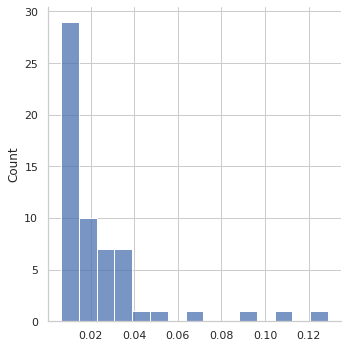

In [82]:
# obliczenie dystansow pomiedzy kolejnymi rekordami z geometrii
jl = joined.distance(joined.shift())
jl = jl[~jl.isna()]
sns.displot(jl)

In [83]:
#wyznaczenie rokordow przed i po
post = joined[joined.level0 != joined.level0.shift()].iloc[1:]
pre = joined.shift()[joined.level0 != joined.level0.shift()].iloc[1:]

In [84]:
jl_l0 = pre.distance(post) #obliczenie dystansow dla kontenera lvl0
jl_l0

<ipython-input-84-ecd0ce40fef8>:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  jl_l0 = pre.distance(post) #obliczenie dystansow dla kontenera lvl0


2     0.088108
3     0.128860
4     0.069446
5     0.106284
6     0.019511
8     0.032377
11    0.022307
16    0.051771
27    0.022671
29    0.036605
30    0.036605
31    0.019171
50    0.037343
51    0.031060
55    0.022671
56    0.033084
57    0.033084
58    0.023148
59    0.039247
dtype: float64

In [85]:
jl = joined.groupby('level0').apply(lambda x: x.distance(x.shift()))
jl

<ipython-input-85-14bd73656cd3>:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  jl = joined.groupby('level0').apply(lambda x: x.distance(x.shift()))


level0    
1       8          NaN
        9     0.016950
        10    0.016950
        59    0.016950
2       2          NaN
3       5          NaN
        31    0.026475
        32    0.009916
        33    0.010839
        34    0.013979
        35    0.013766
        36    0.006403
        37    0.006403
        38    0.019201
        39    0.010839
        40    0.024298
        41    0.016516
        42    0.024796
        43    0.009916
        44    0.026475
        45    0.024298
        46    0.010839
        47    0.025546
        48    0.006403
        49    0.011341
4       27         NaN
        28    0.014415
        30    0.000000
        55    0.014415
        57    0.000000
5       6          NaN
        7     0.009328
        11    0.012126
        12    0.012126
        13    0.009328
        14    0.009328
        15    0.012126
        58    0.000000
6       3          NaN
        50    0.021155
7       0          NaN
        1     0.028786
        16    0.021367


In [86]:
jl = jl[~jl.isna()]
jl

level0    
1       9     0.016950
        10    0.016950
        59    0.016950
3       31    0.026475
        32    0.009916
        33    0.010839
        34    0.013979
        35    0.013766
        36    0.006403
        37    0.006403
        38    0.019201
        39    0.010839
        40    0.024298
        41    0.016516
        42    0.024796
        43    0.009916
        44    0.026475
        45    0.024298
        46    0.010839
        47    0.025546
        48    0.006403
        49    0.011341
4       28    0.014415
        30    0.000000
        55    0.014415
        57    0.000000
5       7     0.009328
        11    0.012126
        12    0.012126
        13    0.009328
        14    0.009328
        15    0.012126
        58    0.000000
6       50    0.021155
7       1     0.028786
        16    0.021367
        17    0.008095
        18    0.010436
        19    0.009044
        20    0.009044
        21    0.008549
        22    0.008549
        23    0.008549


(array([6., 8., 1., 0., 1., 0., 1., 1., 0., 1.]),
 array([0.01917078, 0.0301397 , 0.04110861, 0.05207753, 0.06304645,
        0.07401536, 0.08498428, 0.0959532 , 0.10692211, 0.11789103,
        0.12885995]),
 <BarContainer object of 10 artists>)

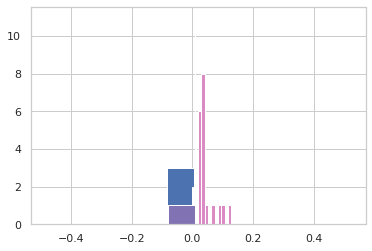

In [87]:

plt.figure()
plt.hist(jl.loc[1].values)
plt.hist(jl.loc[3].values)
plt.hist(jl.loc[4].values)
plt.hist(jl.loc[5].values)
plt.hist(jl.loc[6].values)
plt.hist(jl.loc[7].values)
plt.hist(jl_l0.values)

(array([8., 3., 2., 3., 1., 0., 2., 0., 0., 1.]),
 array([ 1800.,  5760.,  9720., 13680., 17640., 21600., 25560., 29520.,
        33480., 37440., 41400.]),
 <BarContainer object of 10 artists>)

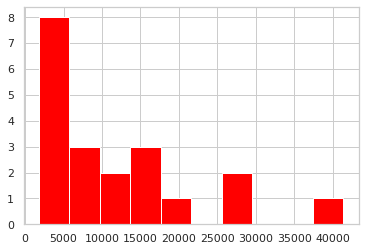

In [107]:
to = joined[
    joined.labels != joined.labels.shift(-1)]
to['covered'] = (to.end - to.start).dt.total_seconds()
plt.figure()
plt.hist(to.covered[to.level0 == 1].values,color='black')
plt.hist(to.covered[to.level0 == 3].values,color='red')


In [89]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go

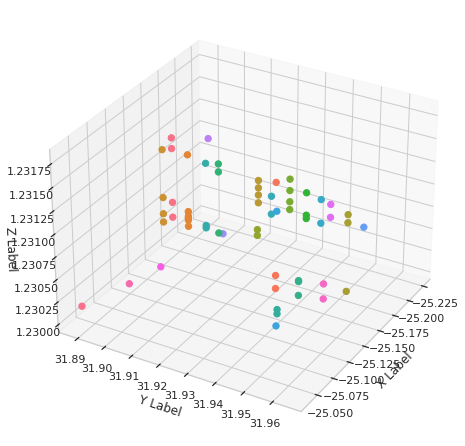

In [90]:
# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

x = joined.lat
y = joined.lon
z = (pd.to_datetime(joined.datetime) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

sc = ax.scatter(x, y, z, s=40, c=joined.labels, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(elev=30, azim=30)


In [91]:
import plotly.graph_objects as go
import numpy as np

x = joined.lat/sum(joined.lat)
y = joined.lon/sum(joined.lon)
z = (pd.to_datetime(joined.datetime) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
z = z/sum(z)

# Create 3D scatter plot
fig = go.Figure()
scatter = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers+lines',
    marker=dict(size=8, color=joined.level1, colorscale='Viridis'),
    line=dict(color='blue', width=2),
)

fig.add_trace(scatter)

# Set axis labels
fig.update_layout(scene=dict(xaxis_title='X Axis', yaxis_title='Y Axis', zaxis_title='Time'))

# Set title
fig.update_layout(title='Interactive 3D Scatter Plot')

# Show the plot
fig.show()


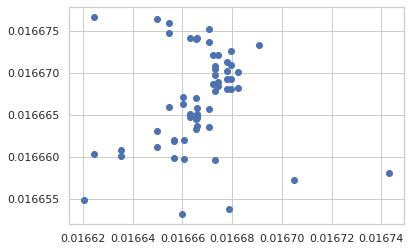

In [92]:
plt.scatter(x,z)

In [93]:
to = joined[
    joined.labels != joined.labels.shift(-1)]
to['covered'] = (to.end - to.start)
to['gap'] = (to.start.shift(-1) - to.end)

In [94]:
pre = to[to.level0 != to.level0.shift(-1)][:-1]
post = to[to.level0 != to.level0.shift()][1:]

[]

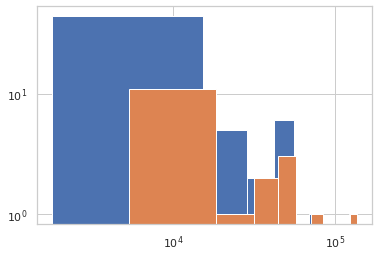

In [95]:
plt.hist(to.gap.dt.total_seconds())
plt.hist(pre.gap.dt.total_seconds())
plt.loglog()

[]

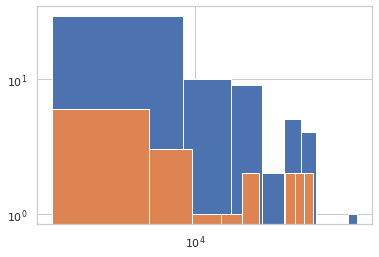

In [96]:
plt.hist(to.covered.dt.total_seconds())
plt.hist(post.covered.dt.total_seconds())
plt.loglog()

In [97]:
time_unit = '1H'  # DEFINE TEMPORAL UNIT
time_agg = TemporalAggregator(time_unit)  # DEFINE TEMPORAL AGGREGATION ALGORITHM
df_processed = time_agg._user_aggregate(1,joined)
df_processed = df_processed.groupby(pd.Grouper(level=1,freq=time_unit)).agg('first')
df_processed.labels = df_processed.labels.fillna(-1)

In [98]:
onepattern = df_processed.labels

In [99]:
list_of_patterns = []
for day, pattern in onepattern.groupby(onepattern.index.floor('d')):
    if pattern.size != 24:
        continue
    list_of_patterns.append(pattern.values)

In [100]:
def sub_cost(Sq,Sp):
    transitions = {}
    for posnum in range(len(Sq)-1): #assuming Sq and Sp have the same size
        state = Sq[posnum]
        next_state = Sp[posnum + 1]
        if state not in transitions.keys():
            transitions[state] = {}
        if next_state not in transitions[state].keys():
            transitions[state][next_state] = 0
        transitions[state][next_state] += 1
    return transitions

In [101]:
import scipy
t_matrix = np.zeros((len(list_of_patterns),len(list_of_patterns)))
for i in range(len(list_of_patterns)):
    for j in range(len(list_of_patterns)):
        t_matrix[i,j] = scipy.spatial.distance.hamming(list_of_patterns[i],list_of_patterns[j])

<Axes: >

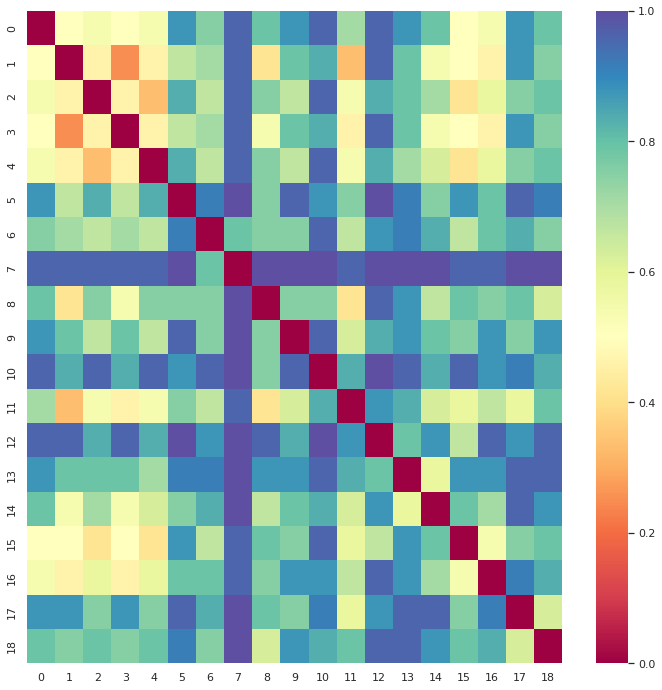

In [102]:
plt.figure(figsize=(12,12))
sns.heatmap(t_matrix,cmap='Spectral')

In [103]:
from sklearn.cluster import AgglomerativeClustering

In [104]:
cls = AgglomerativeClustering(affinity='precomputed',linkage='average',distance_threshold=.3,n_clusters=None)
cls_res = cls.fit_predict(t_matrix)
cls_res

/home/dteodorczyk/.conda/envs/boars3109/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



array([13,  0, 17,  0, 12,  9,  8, 15, 14, 16, 11,  7, 10,  4,  6,  3,  5,
        1,  2])

In [105]:
np.repeat(cls_res,24).shape

(456,)

In [110]:
len(df_days)/len(cls_res)

25.68421052631579

In [106]:
df_days = df_processed
df_days['cls'] = np.repeat(cls_res,24)

ValueError: Length of values (456) does not match length of index (488)

In [ ]:
df_days_compressed = df_days.drop_duplicates()
df_days_compressed = df_days_compressed[~df_days_compressed.isna().any(axis=1)]

NameError: name 'df_days' is not defined

In [ ]:
cmap = plt.cm.viridis
grouped = df_days_compressed.groupby('cls')
for clas, vals in grouped:
    res = vals.groupby(vals.index.floor('d')).apply(lambda x: (x.end - x.start).dt.total_seconds())
    color = cmap(clas/len(grouped))
    sns.kdeplot(res,color=color,label=str(clas))
    plt.legend()
#     plt.loglog()

NameError: name 'df_days_compressed' is not defined

In [ ]:
cmap = plt.cm.viridis
grouped = df_days_compressed.groupby('cls')
for clas, vals in grouped:
    vals = gpd.GeoDataFrame(vals)
    res = vals.groupby(vals.index.floor('d')).apply(lambda x: x.distance(x.shift()))
    color = cmap(clas/len(grouped))
    sns.kdeplot(res,color=color,label=str(clas))
    plt.legend()
#     plt.loglog()

NameError: name 'df_days_compressed' is not defined

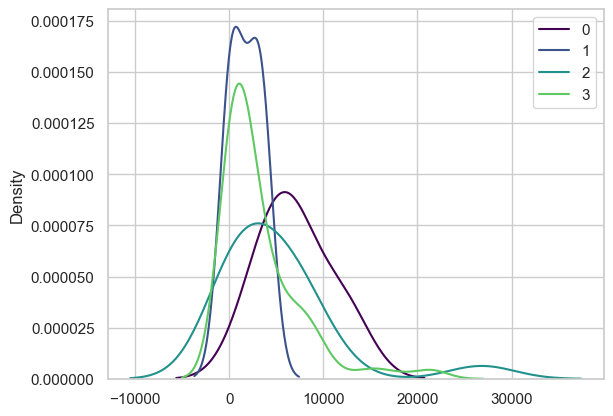

In [ ]:
cmap = plt.cm.viridis
grouped = df_days_compressed.groupby('cls')
for clas, vals in grouped:
    res = vals.groupby(vals.index.floor('d')).apply(lambda x: (x.shift(-1).start - x.end).dt.total_seconds())
    color = cmap(clas/len(grouped))
    sns.kdeplot(res,color=color,label=str(clas))
    plt.legend()
#     plt.loglog()

In [ ]:
np.unique(cls_res,return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([ 13, 113,   3,  19], dtype=int64))